In [21]:
import os
import sys
import polars as pl
import plotly.express as px
import numpy as np
import polars.selectors as cs

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)

In [22]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col("gmp343_corrected") - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
    .agg([
            cs.numeric().mean(),
            pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
            pl.col("gmp343_corrected").var().alias("gmp343_corrected_var"),
            pl.col("gmp343_temperature").max().alias("gmp343_temperature_max"),
            pl.col("enclosure_bme280_temperature").max().alias("enclosure_bme280_temperature_max"),
        ]) \
    .sort("system_id") \
    .with_columns(system_name = "ACROPOLIS-" + pl.col('system_id').cast(pl.String))

In [23]:
temp_filter = 31.0

In [24]:
df_sbs = df.filter(pl.col("diff").is_not_nan()) \
    .group_by(["system_id", "system_name"]) \
    .agg([
            (pl.col("diff").mean()).alias("MEAN"),
            (np.abs(pl.col("diff"))).mean().alias("MAE"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("RMSE"),
            (pl.col("gmp343_temperature").max()),
        ]) \
    .sort("system_id") \
    .with_columns(high_temp = pl.when(pl.col("gmp343_temperature") > temp_filter).then(True).otherwise(False))

In [25]:
df_sbs_stable_temp = df.filter(pl.col("diff").is_not_nan()) \
    .filter(pl.col("gmp343_temperature") < temp_filter) \
    .group_by(["system_id", "system_name"]) \
    .agg([
            (pl.col("diff").mean()).alias("MEAN"),
            (np.abs(pl.col("diff"))).mean().alias("MAE"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("RMSE"),
            (pl.col("gmp343_temperature").max()),
        ]) \
    .sort("system_id") \
    .with_columns(high_temp = pl.when(pl.col("gmp343_temperature") > temp_filter).then(True).otherwise(False))

In [26]:
df_daily_mean = df.sort("datetime") \
    .with_columns(pl.col("datetime").dt.date().alias("date")) \
    .group_by(["date", "system_name", "system_id"]) \
    .agg([
        (pl.col("diff").mean()).alias("daily_mean"),
        (pl.col("diff").median()).alias("daily_median")
        ]) \
    .sort("system_id")

fig = px.scatter(df, x="datetime", y="gmp343_temperature_max", color = "system_name")
fig.show()
fig = px.scatter(df, x="datetime", y="enclosure_bme280_temperature_max", color = "system_name")
fig.show()
fig = px.scatter(df, x="datetime", y="diff", color = "system_name")
fig.show()
fig = px.scatter(df_daily_mean, x="date", y="daily_mean", color = "system_name")
fig.show()
fig = px.scatter(df_daily_mean, x="date", y="daily_median", color = "system_name")
fig.show()

In [27]:
fig = px.scatter(df_sbs, x="system_name", y="MAE")
fig.show()
fig = px.scatter(df_sbs, x="system_name", y="RMSE", color = "high_temp")
fig.show()
fig = px.scatter(df_sbs_stable_temp, x="system_name", y="RMSE", color = "high_temp")
fig.show()

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import polars as pl
import numpy as np

def plot_scatter(df1: pl.DataFrame,
                              df2: pl.DataFrame,
                              titles=("Plot 1", "Plot 2"),
                              figsize=(8, 4),
                              dpi=100,
                              jitter_width=0.05):
    """
    Zeichnet zwei nebeneinanderstehende RMSE-/MAE-Scatterplots,
    wobei jeder Sensor (Zeile) denselben Jitter in beiden Plots erhält
    und die Punkte je nach 'high_temp' farblich unterschieden werden.

    Parameters:
      df1, df2     : Polars-DataFrames mit 'RMSE', 'MAE' und 'high_temp' (bool)
      titles       : Tupel mit Titeln für die beiden Subplots
      figsize      : Gesamtgröße (width, height) in Zoll
      dpi          : Auflösung
      jitter_width : maximale Abweichung ± davon um 1/3 bzw. 2/3
    """
    n = df1.height
    # einmalige Jitter-Offsets pro Sensor erzeugen
    np.random.seed(0)
    jitter_rmse = np.random.uniform(-jitter_width, jitter_width, size=n)
    jitter_mae  = np.random.uniform(-jitter_width, jitter_width, size=n)

    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharey=True)

    for ax, df, title in zip(axes, (df1, df2), titles):
        # Listen für High-Temp und Normal-Temp
        x_high, y_high = [], []
        x_low,  y_low  = [], []

        # Jitter-Offsets konsistent pro Sensor verwenden
        for i, row in enumerate(df.iter_rows(named=True)):
            x_r = 1/3 + jitter_rmse[i]
            y_r = row["RMSE"]
            x_m = 2/3 + jitter_mae[i]
            y_m = row["MAE"]

            if row["high_temp"]:
                x_high.extend([x_r, x_m])
                y_high.extend([y_r, y_m])
            else:
                x_low.extend([x_r, x_m])
                y_low.extend([y_r, y_m])

        # Scatter für beide Gruppen
        ax.scatter(x_low,  y_low,  color="#0072B2",  alpha=0.7, label=(f"Temparatures < {temp_filter}°C"))
        ax.scatter(x_high, y_high, color="#D55E00",   alpha=0.7, label=f"Includes Temperatures > {temp_filter}°C")

        # Baseline bei y=0
        ax.plot([0, 1], [0, 0], color='black', linestyle='--', linewidth=1)

        # Achsen-Formatierung
        ax.set_xlim(0, 1)
        ax.set_xticks([1/3, 2/3])
        ax.set_xticklabels(["RMSE", "MAE"])
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        
    # Gemeinsames Y-Label
    axes[0].set_ylabel("CO₂ hourly mean error (ppm)")
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=2,
               frameon=False)

    fig.tight_layout()
    plt.show()

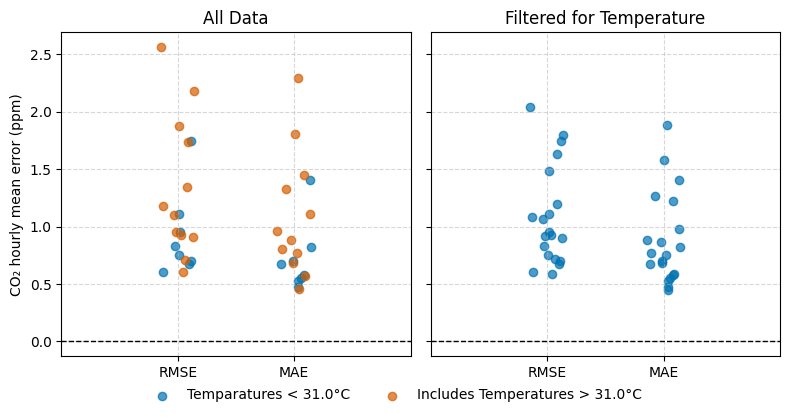

In [29]:
plot_scatter(df1=df_sbs, df2=df_sbs_stable_temp, 
            titles=("All Data", "Filtered for Temperature"),
            figsize=(8, 4),
            dpi=100)

In [30]:
# 144 * 10 minute intervals in 1 day - 3 * 10 min intervals in one calibration
# 24* 1h interval in 1 day

df_plot = df.sort("datetime") \
    .group_by(["system_name", "system_id"]) \
    .agg((pl.col("gmp343_corrected").count() / 24).cast(int).alias("sbs_days")) \
    .join(df_sbs, on="system_id") \
    .drop("^.*_right$") \
    .sort("sbs_days")

fig = px.scatter(df_plot, x="system_name", y="sbs_days")
fig.show()